In [34]:
# ============================================================
# 🔧 CONFIGURATION (edit these as needed)
# ============================================================
import os

config = {
    "image_folder": "../../../SparseSamplingCS-AE-RL/data/faces/ai/",  # e.g. "./images"
    "image_size": 128,         # resize all images to (image_size, image_size)
    "batch_size": 32,
    "epochs": 30,
    "learning_rate": 1e-3,
    "test_samples_to_show": 8,
    "train_split": 0.7,
    "val_split": 0.15,
    "num_workers": 2,
    "seed": 42
}

# ============================================================
# IMPORTS
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "text.latex.preamble": r"\usepackage{amsmath}",  # <-- add this
})
# ============================================================
# DEVICE SELECTION
# ============================================================
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# ============================================================
# 🌱 SET SEED
# ============================================================
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
random.seed(config["seed"])

# ============================================================
# DATASET LOADING AND SPLITTING
# ============================================================
transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(config["image_folder"], transform=transform)
n_total = len(dataset)
n_train = int(config["train_split"] * n_total)
n_val = int(config["val_split"] * n_total)
n_test = n_total - n_train - n_val

train_data, val_data, test_data = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True, num_workers=config["num_workers"])
val_loader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=False, num_workers=config["num_workers"])
test_loader = DataLoader(test_data, batch_size=config["batch_size"], shuffle=False, num_workers=config["num_workers"])

print(f"Dataset sizes -> Train: {n_train}, Val: {n_val}, Test: {n_test}")

# ============================================================
# CONVOLUTIONAL AUTOENCODER MODEL
# ============================================================
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# ============================================================
# TRAINING LOOP
# ============================================================
train_losses, val_losses = [], []

for epoch in range(config["epochs"]):
    model.train()
    train_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, imgs)
            val_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{config['epochs']}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



Using device: cuda
Dataset sizes -> Train: 3241, Val: 694, Test: 695
Epoch [1/30], Train Loss: 0.0228, Val Loss: 0.0057
Epoch [2/30], Train Loss: 0.0043, Val Loss: 0.0032
Epoch [3/30], Train Loss: 0.0028, Val Loss: 0.0021
Epoch [4/30], Train Loss: 0.0020, Val Loss: 0.0018
Epoch [5/30], Train Loss: 0.0018, Val Loss: 0.0016
Epoch [6/30], Train Loss: 0.0016, Val Loss: 0.0015
Epoch [7/30], Train Loss: 0.0014, Val Loss: 0.0013
Epoch [8/30], Train Loss: 0.0015, Val Loss: 0.0012
Epoch [9/30], Train Loss: 0.0012, Val Loss: 0.0011
Epoch [10/30], Train Loss: 0.0011, Val Loss: 0.0010
Epoch [11/30], Train Loss: 0.0011, Val Loss: 0.0014
Epoch [12/30], Train Loss: 0.0010, Val Loss: 0.0009
Epoch [13/30], Train Loss: 0.0010, Val Loss: 0.0009
Epoch [14/30], Train Loss: 0.0009, Val Loss: 0.0009
Epoch [15/30], Train Loss: 0.0009, Val Loss: 0.0008
Epoch [16/30], Train Loss: 0.0009, Val Loss: 0.0008
Epoch [17/30], Train Loss: 0.0008, Val Loss: 0.0010
Epoch [18/30], Train Loss: 0.0008, Val Loss: 0.0007
Epoc

### Plot the learning curve

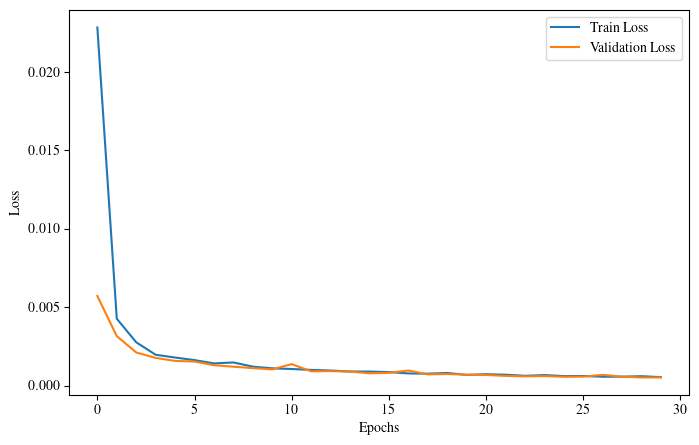

In [ ]:
# ============================================================
# LEARNING CURVE
# ============================================================
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
#plt.title("Autoencoder Learning Curve")
#plt.savefig("AE-learningcurve.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

### Pick up an image from the test set, encode it, and then reconstruct it using the decoder. 

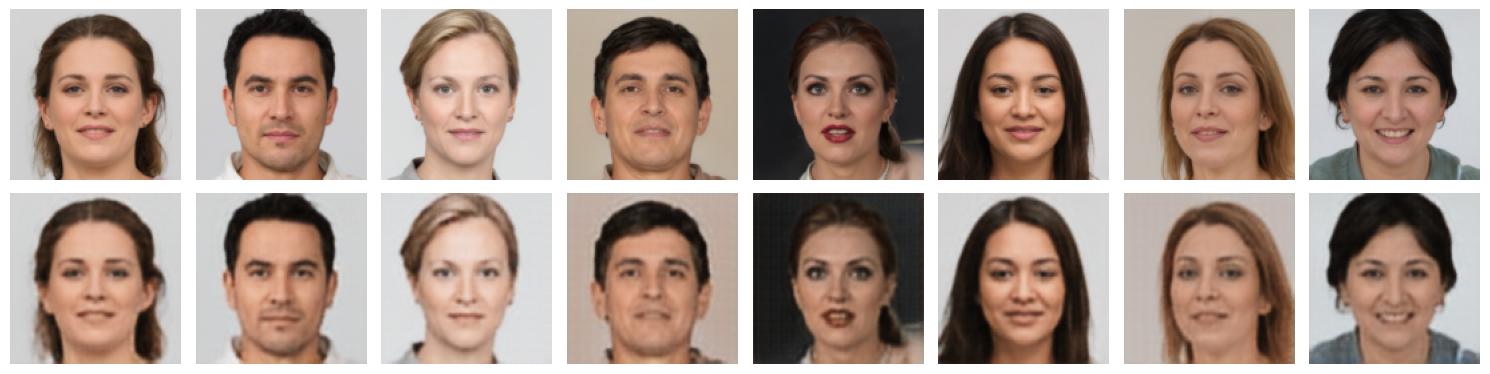

In [ ]:
# ============================================================
# RECONSTRUCTION VISUALIZATION
# ============================================================
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs[:config["test_samples_to_show"]].to(device)
    outputs = model(imgs)
    imgs = imgs.cpu()
    outputs = outputs.cpu()

# Display
fig, axes = plt.subplots(2, config["test_samples_to_show"], figsize=(15, 4))
for i in range(config["test_samples_to_show"]):
    axes[0, i].imshow(np.transpose(imgs[i], (1, 2, 0)))
    #axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(np.transpose(outputs[i], (1, 2, 0)))
    #axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.tight_layout()
#plt.savefig("AE-reconstruction.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

### Ramdomly sample from the latent space and do the reconstuction

Latent space shape: torch.Size([128, 16, 16])


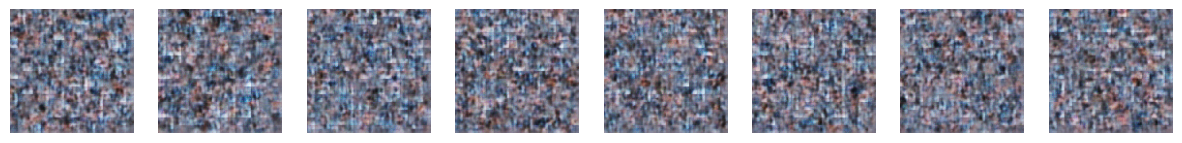

In [ ]:
# ============================================================
#  LATENT SPACE SAMPLING AND DECODING
# ============================================================
# To sample from latent space, we need to know its shape after encoding.
with torch.no_grad():
    sample_img, _ = next(iter(train_loader))
    sample_img = sample_img[:1].to(device)
    latent = model.encoder(sample_img)
    latent_shape = latent.shape[1:]  # (channels, h, w)

print(f"Latent space shape: {latent_shape}")

# Sample random latent vectors
n_samples = 8
random_latent = torch.randn((n_samples, *latent_shape)).to(device)

# Decode
with torch.no_grad():
    generated = model.decoder(random_latent).cpu()

# Visualize generated samples
fig, axes = plt.subplots(1, n_samples, figsize=(15, 2))
for i in range(n_samples):
    axes[i].imshow(np.transpose(generated[i], (1, 2, 0)))
    axes[i].axis("off")
#    axes[i].set_title(f"Sample {i+1}")
#plt.suptitle("Decoder Output from Random Latent Samples")
#plt.savefig("AE-randomsampling.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

### Create some linear combinations of the latent representaiton and then use the decoder to reconstruct the image. 

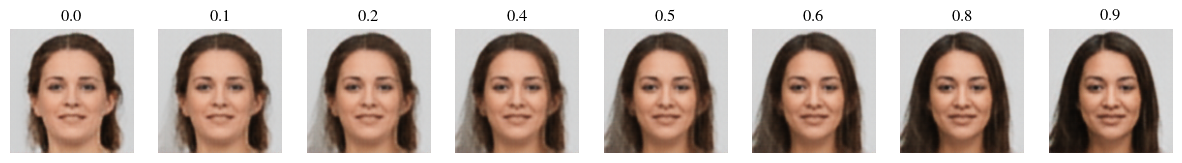

In [ ]:
with torch.no_grad():
    img1, _ = test_data[0]
    img2, _ = test_data[5]
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    z1 = model.encoder(img1)
    z2 = model.encoder(img2)

    steps = 8
    interpolations = []
    for alpha in np.linspace(0, 1, steps):
        z = (1 - alpha) * z1 + alpha * z2
        recon = model.decoder(z).cpu()
        interpolations.append(recon.squeeze(0))

# Visualize interpolation
fig, axes = plt.subplots(1, steps, figsize=(15, 2))
for i, img in enumerate(interpolations):
    axes[i].imshow(np.transpose(img, (1, 2, 0)))
    axes[i].axis("off")
    axes[i].set_title(f"{i/steps:.1f}")
#plt.suptitle("Latent Space Interpolation")
#plt.savefig("AE-latentintepolation.pdf", bbox_inches="tight", pad_inches=0)
plt.show()


Iter [1/500]  Loss: 3.295673e-02
Iter [100/500]  Loss: 1.799582e-03
Iter [200/500]  Loss: 6.621559e-04
Iter [300/500]  Loss: 4.379718e-04
Iter [400/500]  Loss: 3.370589e-04
Iter [500/500]  Loss: 2.746785e-04


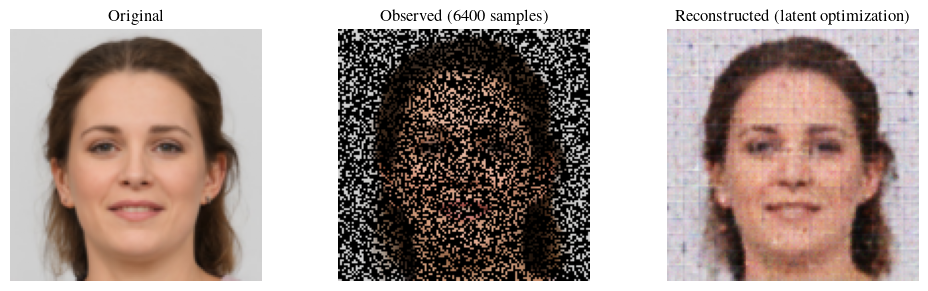

In [ ]:
# ============================================================
# ✅ Latent-space reconstruction using only measured pixels
# ============================================================
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    test_imgs, _ = next(iter(test_loader))
test_img = test_imgs[0:1].to(device)

# choose number of sampled pixels
n_samples = 6400   # try 0, 10, 100, 1000, etc.
img_size = config["image_size"]

# ---- create 2D spatial mask ----
mask2d = torch.zeros((1, 1, img_size, img_size), device=device)
xy_idx = torch.randint(0, img_size * img_size, (n_samples,), device=device)
mask2d.view(-1)[xy_idx] = 1.0
mask = mask2d.repeat(1, 3, 1, 1)  # same mask across RGB

# measured sparse image
measured = test_img * mask

# ---- initialize latent randomly (not from encoder!) ----
with torch.no_grad():
    dummy_input = torch.randn_like(test_img)
    z = model.encoder(dummy_input)  # just to get correct shape

z = torch.randn_like(z).to(device).requires_grad_(True)  # random latent
optimizer_z = optim.Adam([z], lr=1e-2)
loss_fn = nn.MSELoss()

# ---- optimization ----
n_iters = 500
for i in range(n_iters):
    optimizer_z.zero_grad()
    recon = model.decoder(z)
    loss = loss_fn(recon * mask, measured)   # match only known pixels
    loss.backward()
    optimizer_z.step()

    if (i + 1) % 100 == 0 or i == 0:
        print(f"Iter [{i+1}/{n_iters}]  Loss: {loss.item():.6e}")

# ---- visualize ----
with torch.no_grad():
    recon_img = model.decoder(z).cpu().squeeze(0)
    sparse_obs = measured.cpu().squeeze(0)
    orig = test_img.cpu().squeeze(0)

def to_img(t): return np.transpose(t.numpy(), (1, 2, 0))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].imshow(to_img(orig))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(to_img(sparse_obs))
axes[1].set_title(f"Observed ({n_samples} samples)")
axes[1].axis("off")

axes[2].imshow(to_img(recon_img))
axes[2].set_title("Reconstructed (latent optimization)")
axes[2].axis("off")

plt.tight_layout()
#plt.savefig("AE-SparseReconstruction6400.pdf", bbox_inches="tight", pad_inches=0)
plt.show()
